In [2]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import glob
import operator
import time 
import shutil
import scipy
import sys
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

pd.set_option("display.max_columns", 100)

In [3]:
%load_ext blackcellmagic

# Read in Data

In [4]:
darshan_df = pd.read_csv("../data/ap-ds-join/cmb-ds-1802-1812.csv")
autoperf_df = pd.read_csv("../data/ap-ds-join/cmb-ap-1802-1812.csv")

# Runtime Breakdown

In [5]:
def run_time_break(ap_df, ds_df):
    io_time_key = [
        "TOTAL_CP_F_POSIX_READ_TIME",
        "TOTAL_CP_F_POSIX_WRITE_TIME",
        "TOTAL_CP_F_POSIX_META_TIME",
        "TOTAL_CP_F_MPI_META_TIME",
        "TOTAL_CP_F_MPI_READ_TIME",
        "TOTAL_CP_F_MPI_WRITE_TIME",
    ]

    # Get an array of sorted indices for the jobids
    ap_jid_sarg = np.argsort(ap_df.zero_batchJobId)
    ds_jid_sarg = np.argsort(ds_df.COBALT_JOBID)

    # Calculate the runtime and time spent on file io and mpi
    cul_io_time = (ds_df[io_time_key].values.sum(axis=1))[ds_jid_sarg]
    cul_mpi_time = (ap_df.zero_stdMpiTime.values * ap_df.zero_numRanks.values)[
        ap_jid_sarg
    ]
    cul_run_time = (ap_df.zero_elapsedTime.values * ap_df.zero_numRanks.values)[
        ap_jid_sarg
    ]

    # Calculate fractional time spent on io, mpi, and computation
    frac_io = cul_io_time / cul_run_time
    frac_mpi = cul_mpi_time / cul_run_time
    frac_comp = 1 - frac_io - frac_mpi
    mask = (
        (frac_io >= 0)
        & (frac_io <= 1)
        & (frac_mpi >= 0)
        & (frac_mpi <= 1)
        & (frac_comp >= 0)
        & (frac_comp <= 1)
    )

    return (
        ap_df.sort_values("zero_batchJobId")[mask],
        ds_df.sort_values("COBALT_JOBID")[mask],
        frac_io[mask],
        frac_mpi[mask],
        frac_comp[mask],
    )

In [6]:
masked_autoperf_df, masked_darshan_df, frac_io, frac_mpi, frac_comp = run_time_break(
    autoperf_df, darshan_df
)
print("Lengths of returned values (should be identical):")
len(masked_autoperf_df), len(masked_darshan_df), len(frac_io), len(frac_mpi), len(
    frac_comp
)

Lengths of returned values (should be identical):


(9891, 9891, 9891, 9891, 9891)

In [7]:
combined_df = pd.concat(
    [
        masked_autoperf_df.reset_index(drop=True),
        masked_darshan_df.reset_index(drop=True),
    ],
    axis=1,
)
print("Length of combined_df (should match above):", len(combined_df))
combined_df["frac_io"] = frac_io
combined_df["frac_mpi"] = frac_mpi
combined_df["frac_comp"] = frac_comp

Length of combined_df (should match above): 9891


In [8]:
# This should return an empty array, meaning all our jobids line up
combined_df[combined_df.zero_batchJobId != combined_df.COBALT_JOBID].values

array([], shape=(0, 1234), dtype=object)

In [14]:
combined_df.to_csv('../data/ap-ds-join/combined-ap-ds-1802-1812.csv')

# XGBoost Models

In [9]:
# Select features and targets for model training
features = (
    combined_df.drop(
        [
            "zero_execName",
            "run_date",
            "zero_userName",
            "zero_threadMode",
            "min_userName",
            "min_execName",
            "min_threadMode",
            "max_execName",
            "max_userName",
            "max_threadMode",
            "av_execName",
            "av_userName",
            "av_threadMode",
            "zero_csJobId",
            "zero_batchJobId",
            "output_local",
            "output_sys",
        ],
        axis=1,
    )
    .select_dtypes(include=[np.number])
    .copy()
)

features = features.drop(["frac_io", "frac_comp", "frac_mpi"], axis=1)
features = features.drop(
    [column for column in features.columns if "unnamed" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if column.isupper()], axis=1
)
features = features.drop(
    [column for column in features.columns if "mpi" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "torus" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "version" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "env" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "debug" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "disable" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "cycle" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "rank" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "jobid" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "batchid" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "rank" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "username" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "execname" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "time" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "numprocesses" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "threads" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "heapmaxused" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "zero_" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "min_" in column.lower()], axis=1
)
features = features.drop(
    [column for column in features.columns if "max_" in column.lower()], axis=1
)
features = features.drop(
    [
        column
        for column in features.columns
        if features[column].max() == features[column].min()
    ],
    axis=1,
)


# Create targets for softmax classification (Binary classification, essentially)
targets_io = np.where(combined_df.frac_io >= 0.5, 1, 0)
targets_comp = np.where(combined_df.frac_comp >= 0.5, 1, 0)
targets_mpi = np.where(combined_df.frac_mpi >= 0.5, 1, 0)

# Softmax classification on all categories, 0 = comp, 1 = mpi, 2 = io
targets_all = np.where(targets_comp == 0, 1, 0) + targets_mpi + (targets_io * 2)

# Create targets for regression
targets_io_regression = combined_df.frac_io
targets_comp_regression = combined_df.frac_comp
targets_mpi_regression = combined_df.frac_mpi

In [13]:
len(targets_all)

9891

In [10]:
# Normalize the fields by average elapsed time per rank
def elapsedTimeNormalization(column):
    return column / combined_df.av_elapsedTime


features = features.apply(elapsedTimeNormalization).fillna(value=0, axis=0)

In [11]:
# Ensure these are the correct columns we want to use as features
for column in features.columns:
    print(column)

av_PEVT_LSU_COMMIT_LD_MISSES
av_PEVT_LSU_COMMIT_CACHEABLE_LDS
av_PEVT_L1P_BAS_MISS
av_PEVT_INST_XU_ALL
av_PEVT_INST_QFPU_ALL
av_PEVT_INST_QFPU_FPGRP1
av_PEVT_L2_HITS
av_PEVT_L2_MISSES
av_PEVT_L2_FETCH_LINE
av_PEVT_L2_STORE_LINE
av_PEVT_NW_USER_PP_SENT
av_PEVT_NW_USER_PP_RECV


In [313]:
# A function that takes our features and targets, and trains a basic XGB Classification model on them
# Returns the accuracy, recall, and precision scores
def classify(features, targets, average='binary'):
    train_examples, test_examples, train_targets, test_targets = train_test_split(
        features.values, targets, test_size=0.2, random_state=0
    )
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(train_examples, train_targets)
    return (
        accuracy_score(test_targets, xgb_model.predict(test_examples)),
        recall_score(test_targets, xgb_model.predict(test_examples), average=average),
        precision_score(test_targets, xgb_model.predict(test_examples), average=average),
    )

In [314]:
# Run classification on File IO
classify(features, targets_io)

(0.9964628600303184, 0.875, 0.9459459459459459)

In [315]:
# Run classification on Computation
classify(features, targets_comp)

(0.9722081859525012, 0.9830065359477124, 0.9810828440965427)

In [316]:
# Run classification on MPI
classify(features, targets_mpi)

(0.9782718544719555, 0.9054878048780488, 0.9611650485436893)

In [320]:
# Run classification on All Targets
classify(features, targets_all, 'macro')

(0.9646286003031834, 0.8865470623660485, 0.9198557696000889)

In [336]:
# A function that takes our features and targets, and does a grid search for the best classifier
# Returns the best estimator produced
def classify_grid(features, targets):
    train_examples, test_examples, train_targets, test_targets = train_test_split(
        features.values, targets, test_size=0.2, random_state=0
    )

    param_grid = {
        "max_depth": [16, 17],
        "n_estimators": [170, 175, 180],
        'colsample_bylevel': [.75],
        'colsample_bynode': [1.0],
        'colsample_bytree': [.75],
        'learning_rate': [0.3],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [.75, 1, 1.25],
        'subsample': [.75, .9, 1],
    }
    grid = GridSearchCV(
        estimator=xgb.XGBClassifier(), param_grid=param_grid, n_jobs=-1, cv=3, verbose=2
    )

    grid.fit(train_examples, train_targets)
    estimator = grid.best_estimator_
    return (
        estimator,
        accuracy_score(test_targets, estimator.predict(test_examples)),
        recall_score(test_targets, estimator.predict(test_examples), average="macro"),
        precision_score(test_targets, estimator.predict(test_examples), average="macro"),
    )

classify_grid(features, targets_all)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  6.6min finished


(XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.75,
               colsample_bynode=1.0, colsample_bytree=0.75, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints=None,
               learning_rate=0.3, max_delta_step=0, max_depth=16,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=180, n_jobs=0, num_parallel_tree=1,
               objective='multi:softprob', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method=None, validate_parameters=False, verbosity=None),
 0.965133906013138,
 0.8893929229324973,
 0.914420476158281)

In [337]:
# A function that takes our features and targets, and trains a basic XGB Regressor model on them
def regressor(features, targets):
    train_examples, test_examples, train_targets, test_targets = train_test_split(
        features.values, targets, test_size=0.2, random_state=0
    )
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(train_examples, train_targets)
    
    prediction = xgb_model.predict(test_examples)
    
    error   = prediction - test_targets
    abs_err = np.abs(error)
    rel_err = 100. * abs_err / test_targets
#     print(np.percentile(rel_err, 25), np.percentile(rel_err, 50), np.percentile(rel_err, 75), np.percentile(rel_err, 95))
    print("Min:", np.percentile(rel_err, 0))
    print("25th:", np.percentile(rel_err, 25))
    print("50th:", np.percentile(rel_err, 50))
    print("75th:", np.percentile(rel_err, 75))
    print("95th:", np.percentile(rel_err, 95))
    print("Max:", np.percentile(rel_err, 100))

In [338]:
# Predict fraction of time spent on File IO
regressor(features, targets_io_regression)

Min: 0.01814646725326978
25th: 5.3824972092399825
50th: 25.58231690555163
75th: 255.29267000988312
95th: 1050352.2978610056
Max: nan


/home/luckierdodge/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


In [339]:
# Estimate fraction of time spent on Computation
regressor(features, targets_comp_regression)

Min: 0.00021692648302680133
25th: 0.36490877320284204
50th: 1.2835184490834302
75th: 4.976852931915088
95th: 30.242211926027654
Max: 3157.286858389763


In [340]:
# Estimate fraction of time spent on MPI
regressor(features, targets_mpi_regression)

Min: 0.002488359601149416
25th: 1.0003557467435331
50th: 3.0983016975201716
75th: 11.06784434438529
95th: 208.34815038238693
Max: 502231088.0259991


(array([8.745e+03, 6.390e+02, 1.700e+02, 8.800e+01, 5.300e+01, 8.000e+01,
        6.300e+01, 3.800e+01, 1.100e+01, 4.000e+00]),
 array([0.        , 0.09692641, 0.19385282, 0.29077924, 0.38770565,
        0.48463206, 0.58155847, 0.67848489, 0.7754113 , 0.87233771,
        0.96926412]),
 <a list of 10 Patch objects>)

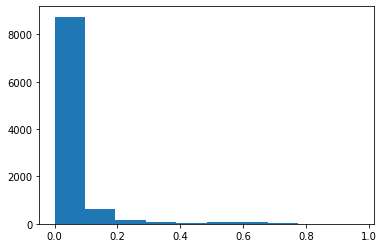

In [279]:
plt.hist(combined_df.frac_io)

(array([ 192.,  195.,  456.,  707.,  658.,  692., 1234., 2535., 2710.,
         512.]),
 array([4.74824413e-06, 1.00004270e-01, 2.00003792e-01, 3.00003313e-01,
        4.00002835e-01, 5.00002357e-01, 6.00001878e-01, 7.00001400e-01,
        8.00000922e-01, 9.00000444e-01, 9.99999965e-01]),
 <a list of 10 Patch objects>)

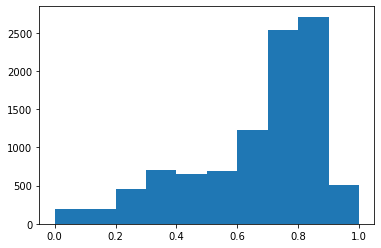

In [280]:
plt.hist(combined_df.frac_comp)

(array([1147., 2900., 2514.,  955.,  749.,  448.,  615.,  403.,   47.,
         113.]),
 array([9.51927373e-09, 9.99704805e-02, 1.99940951e-01, 2.99911422e-01,
        3.99881893e-01, 4.99852364e-01, 5.99822835e-01, 6.99793306e-01,
        7.99763777e-01, 8.99734248e-01, 9.99704719e-01]),
 <a list of 10 Patch objects>)

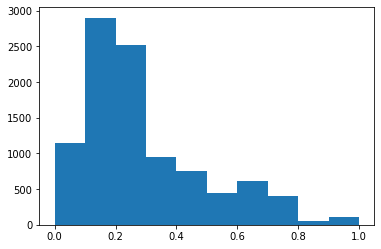

In [281]:
plt.hist(combined_df.frac_mpi)